# Data Analyst Job Market Analysis: Skills, Salary & Experience

**Author:** Shane McCabe | **Date:** October 2025 | **Dataset:** 46,000+ Unique Data Analyst Job Postings 

---

## Executive Summary

This analysis examines the data analyst job market to identify which skills command the highest salaries and whether strategic skill acquisition or career progression matters more for compensation growth.

**Key Findings**
- **Experience vs Skills:** Experience is the strongest salary predictor (r=0.332)
- **Top Earning Skills:** Python ($9,608), snowflake($13,252), aws ($16,952),  show salary premiums
- **Independent Value:** Python maintains strong salary correlation even after controlling for experience
- **Career Growth:** Entry → Senior progression yields 45.9% salary increase ($83K → $121K)
Entry → Senior salary growth: +$38,276 (45.9%)

**Methods**
- Data Cleaning & Feature Engineering: Filtering, handling missing values, and creating skill category variables
- Correlation Analysis: Pearson and Spearman correlation to identify relationships between skills and salary
- Hypothesis Testing: Statistical tests (t-tests) to validate salary differences between skill groups
- Data Visualization: Interactive Plotly charts and static visualizations for insight communication

---

## Data Collection & Processing Pipeline

This analysis is built on a comprehensive data engineering pipeline that collected, cleaned, and standardized job postings from multiple sources.

### Data Sources

**Final Dataset:** 46,610 unique data analyst job postings  
**Original Collection:** 95,740 jobs (51.3% deduplication rate)  
**Date Range:** January 2024 - October 2025  
**Geography:** United States

#### Source Breakdown:

1. **Adzuna API** (October 2025)
   - Jobs collected: 16,350
   - Method: REST API integration
   - Strength: 100% salary data coverage
   - Rate limit: 5,000 calls/month (free tier)

2. **Google Jobs Search** (April 2025)
   - Jobs collected: 61,912
   - Method: Kaggle dataset
   - Strength: Largest volume, diverse sources
   - Dataset: `lukebarousse/data_jobs` via Kaggle

3. **LinkedIn** (2022-2025)
   - Jobs collected: 3,689 (combined from 2 datasets)
   - Method: Kaggle datasets
   - Strength: Professional network data
   - Datasets: `joykimaiyo18` and `cedricaubin`

4. **Indeed** (2024)
   - Jobs collected: 13,761
   - Method: Kaggle dataset (biweekly scrapes)
   - Strength: Full year 2024 coverage
   - Dataset: `artemfedorov/vacancies-from-indeed-scraped-biweekly-2024`

---

### Data Quality Assessment

#### Completeness by Field:
- Job Title: 100%
- Company Name: 100%
- Location: 100%
- State: 63.5% (Remote: 38.5%, Unknown: 35.0%)
- **Salary Data: 25.1%** (11,720 jobs)
- Experience Level: 99.9%
- Posted Date: 13.5%
- Skills: 73.7%

#### Known Limitations:
1. **Salary coverage:** Only 25% include compensation data
2. **Geographic gaps:** 35% couldn't be mapped to specific states
3. **Temporal sparsity:** Limited posted dates (13.5%)
4. **Source bias:** Heavy weighting toward Google Jobs aggregator

---

### Technical Implementation

**Languages & Libraries:**
- Python 3.12
- Pandas, NumPy (data manipulation)
- Requests (API calls)
- BeautifulSoup (attempted scraping)
- FuzzyWuzzy (deduplication)
- SQLite (data storage)

**File Structure:**
```
data/
├── raw/                    # Original downloads (gitignored)
├── processed/              # Cleaned individual sources
│   ├── adzuna_cleaned.csv
│   ├── google_search_cleaned.csv
│   ├── linkedin_data_cleaned.csv
│   ├── indeed_2024_cleaned.csv
│   └── usajobs_analysts.csv
└── jobs_analysis_ready.csv # Final dataset (46,610 jobs)
```

**Pipeline Scripts:**
```
scripts/
├── fetch_adzuna_data.py         # API collection
├── fetch_usajobs_data.py        # Government API
├── clean_*.py                   # Source-specific cleaning
├── create_final_dataset.py      # Combine all sources
├── deduplicate_final.py         # Fuzzy matching dedup
└── final_data_preparation.py    # Feature engineering
```
---

## Table of Contents

1. Setup and Load Data
2. Data Cleaning
3. Feature Engineering: Skill Extraction
4. Encode Experience Level
5. Skills vs Salary Correlation
6. Statistical Testing: Skill Salary Differences
7. Experience Level vs Salary
8. Partial Correlation: Controlling for Experience Level
9. Skill Co-occurrence Analysis
10. Key Findings Summary
11. Actionable Insights for Job Seekers

---

<a id="1-setup-and-load-data"></a>
## 1. Setup and Load Data

Import necessary packages and configure settings. Load the processed job postings dataset, which contains salary information, required skills, and job characteristics for data analyst positions.

In [67]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Utilities
import warnings
warnings.filterwarnings('ignore')
import os

# Configuration
pio.renderers.default = 'png'  # Ensure Plotly charts render properly in github/nbviwer
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [68]:
# Load processed job data
# Using relative path for reproducibility
df = pd.read_csv('../data/processed/jobs_with_work_type_v2.csv', low_memory=False)

# Quick dataset overview
print(f"Dataset loaded: {len(df):,} job postings")
print(f"Features: {len(df.columns)} columns")
print(f"\nSample columns: {df.columns.tolist()[:10]}...")  # Show first 10 to avoid clutter

Dataset loaded: 46,610 job postings
Features: 25 columns

Sample columns: ['job_id', 'title', 'company_name', 'location', 'state', 'posted_date_clean', 'year', 'month', 'quarter', 'salary_min']...


<a id="1-setup-and-load-data"></a>
## 2. Data Cleaning

Focusing on jobs with reported salary data to ensure accurate compensation analysis. This filters out positions where salary information is missing or listed as negotiable.

In [69]:
# Filter to jobs with salary information
df_salary = df[df['salary_avg'].notna()].copy()

# Dataset summary
print(f"Jobs with salary data: {len(df_salary):,} of {len(df):,} ({len(df_salary)/len(df)*100:.1f}%)")
print(f"\nSalary Statistics:")
print(f"  Range:  ${df_salary['salary_avg'].min():,.0f} - ${df_salary['salary_avg'].max():,.0f}")
print(f"  Mean:   ${df_salary['salary_avg'].mean():,.0f}")
print(f"  Median: ${df_salary['salary_avg'].median():,.0f}")

Jobs with salary data: 11,706 of 46,610 (25.1%)

Salary Statistics:
  Range:  $9 - $550,000
  Mean:   $74,851
  Median: $80,000


### Data Quality Check: Hourly vs Annual Salaries

Since the salary range is $9-$550,000, we need to investigate how many jobs in our dataset have hourly salary data. Values under $100 are flagged as they likely represent hourly rates rather than annual compensation in thousands.

In [70]:
# Identify potential hourly wage entries (values < $100)
hourly_suspected = df_salary[df_salary['salary_avg'] < 100]

print(f"Suspected hourly wage entries: {len(hourly_suspected):,} ({len(hourly_suspected)/len(df_salary)*100:.1f}%)")
print(f"\nMost common values:")
print(hourly_suspected['salary_avg'].value_counts().head(10))
print(f"\nDistribution:")
print(hourly_suspected['salary_avg'].describe())

Suspected hourly wage entries: 3,624 (31.0%)

Most common values:
salary_avg
57.5    209
30.0    165
33.5    135
32.5    108
15.0    102
20.0     99
25.0     92
60.0     91
35.0     88
22.5     86
Name: count, dtype: int64

Distribution:
count    3624.000000
mean       40.224161
std        19.353863
min         9.000000
25%        25.000000
50%        35.000000
75%        55.000000
max        99.000000
Name: salary_avg, dtype: float64


### Convert Hourly Wages to Annual Salaries
Identifying and converting hourly wage entries to annual salaries for consistent analysis. Values under $100 are converted using standard full-time calculations (40 hrs/week × 52 weeks = 2,080 hrs/year).

In [71]:
# Convert hourly wages to annual salaries (40 hrs/week × 52 weeks = 2,080 hrs/year)
HOURS_PER_YEAR = 2080
HOURLY_THRESHOLD = 100  # Anything under $100 is likely hourly

df_salary['salary_converted'] = df_salary['salary_avg'].apply(
    lambda x: x * HOURS_PER_YEAR if x < HOURLY_THRESHOLD else x
)

# Show conversion impact
converted_count = (df_salary['salary_avg'] < HOURLY_THRESHOLD).sum()
print(f"✓ Converted {converted_count:,} hourly wages to annual salaries")

print(f"\nBefore conversion:")
print(f"  Min:  ${df_salary['salary_avg'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_avg'].mean():,.0f}")

print(f"\nAfter conversion:")
print(f"  Min:  ${df_salary['salary_converted'].min():,.0f}")
print(f"  Mean: ${df_salary['salary_converted'].mean():,.0f}")

# Use converted salary going forward
df_salary['salary_avg'] = df_salary['salary_converted']
df_salary = df_salary.drop(columns=['salary_converted'])

✓ Converted 3,624 hourly wages to annual salaries

Before conversion:
  Min:  $9
  Mean: $74,851

After conversion:
  Min:  $100
  Mean: $100,741


In [72]:
# Analyze salary distribution for outliers
import numpy as np

print("\nSALARY DISTRIBUTION ANALYSIS")
print("="*60)

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = df_salary['salary_avg'].quantile(p/100)
    print(f"{p:2}th percentile: ${val:>10,.0f}")

print("\n" + "="*60)

# Check extreme values
low_outliers = df_salary[df_salary['salary_avg'] < 30000]
print(f"\nJobs with salary < $30k: {len(low_outliers):,} ({len(low_outliers)/len(df_salary)*100:.1f}%)")

high_outliers = df_salary[df_salary['salary_avg'] > 200000]
print(f"Jobs with salary > $200k: {len(high_outliers):,} ({len(high_outliers)/len(df_salary)*100:.1f}%)")


SALARY DISTRIBUTION ANALYSIS
 1th percentile: $    20,800
 5th percentile: $    39,666
10th percentile: $    47,840
25th percentile: $    68,640
50th percentile: $    94,496
75th percentile: $   124,800
90th percentile: $   160,000
95th percentile: $   189,541
99th percentile: $   242,229


Jobs with salary < $30k: 267 (2.3%)
Jobs with salary > $200k: 447 (3.8%)


### Remove Salary Outliers

Filtering to realistic salary ranges ($30K-$200K) to remove data entry errors and extreme outliers that could skew the analysis.

In [73]:
# Define realistic salary bounds for data analyst positions
SALARY_MIN = 30000   # Entry-level threshold
SALARY_MAX = 200000  # Senior/management threshold

# Count outliers before filtering
outliers_low = (df_salary['salary_avg'] < SALARY_MIN).sum()
outliers_high = (df_salary['salary_avg'] > SALARY_MAX).sum()

# Filter to reasonable salary range
df_salary = df_salary[
    (df_salary['salary_avg'] >= SALARY_MIN) &
    (df_salary['salary_avg'] <= SALARY_MAX)
].copy()

print(f"Outliers removed: {outliers_low + outliers_high:,} jobs ({outliers_low} below ${SALARY_MIN:,}, {outliers_high} above ${SALARY_MAX:,})")
print(f"Final dataset: {len(df_salary):,} jobs")
print(f"\nSalary range: ${df_salary['salary_avg'].min():,.0f} - ${df_salary['salary_avg'].max():,.0f}")
print(f"Mean: ${df_salary['salary_avg'].mean():,.0f} | Median: ${df_salary['salary_avg'].median():,.0f}")

Outliers removed: 714 jobs (267 below $30,000, 447 above $200,000)
Final dataset: 10,992 jobs

Salary range: $30,111 - $200,000
Mean: $97,381 | Median: $93,600


## 3. Feature Engineering: Skill Extraction

Creating binary indicator columns for each technical tool and general skill mentioned in job postings. This enables quantitative analysis of skill demand and correlation with salary.

In [74]:
# Define skill categories for analysis
SOFTWARE_SKILLS = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery',
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git'
]

GENERAL_SKILLS = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl',
    'data warehouse', 'data modeling', 'agile', 'api'
]

def create_skill_columns(df, software_list, general_list):
    """Create binary indicator columns for each skill mentioned in job postings"""
    all_skills = software_list + general_list
    
    # Create binary columns (1 if skill mentioned, 0 otherwise)
    for skill in all_skills:
        df[f'skill_{skill}'] = df['skills_extracted_text'].str.contains(
            skill, case=False, na=False, regex=False
        ).astype(int)
    
    return df

# Apply skill extraction
df_salary = create_skill_columns(df_salary, SOFTWARE_SKILLS, GENERAL_SKILLS)

print(f"✓ Created {len(SOFTWARE_SKILLS) + len(GENERAL_SKILLS)} skill indicators:")
print(f"  • {len(SOFTWARE_SKILLS)} technical tools")
print(f"  • {len(GENERAL_SKILLS)} general skills")

✓ Created 43 skill indicators:
  • 32 technical tools
  • 11 general skills


In [75]:
# Define skill categories for analysis
SOFTWARE_SKILLS = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery',
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git'
]

GENERAL_SKILLS = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl',
    'data warehouse', 'data modeling', 'agile', 'api'
]

def create_skill_columns(df, software_list, general_list):
    """Create binary indicator columns for each skill mentioned in job postings"""
    all_skills = software_list + general_list
    
    # Create binary columns (1 if skill mentioned, 0 otherwise)
    for skill in all_skills:
        df[f'skill_{skill}'] = df['skills_extracted_text'].str.contains(
            skill, case=False, na=False, regex=False
        ).astype(int)
    
    return df

# Apply skill extraction
df_salary = create_skill_columns(df_salary, SOFTWARE_SKILLS, GENERAL_SKILLS)

print(f"✓ Created {len(SOFTWARE_SKILLS) + len(GENERAL_SKILLS)} skill indicators:")
print(f"  • {len(SOFTWARE_SKILLS)} technical tools")
print(f"  • {len(GENERAL_SKILLS)} general skills")

✓ Created 43 skill indicators:
  • 32 technical tools
  • 11 general skills


## 4. Encode Experience Level

Converting categorical experience levels to ordinal numeric values (1=Entry to 5=Executive) to enable correlation analysis with salary. Jobs without specified experience levels are excluded from further analysis.

In [76]:
# Create ordinal encoding for experience level
experience_mapping = {
    'Entry': 1,
    'Mid': 2,
    'Senior': 3,
    'Lead': 4,
    'Executive': 5,
    'Not Specified': np.nan
}

df_salary['experience_numeric'] = df_salary['experience_level'].map(experience_mapping)

# Filter to jobs with complete salary and experience data
df_analysis = df_salary[df_salary['experience_numeric'].notna()].copy()

print(f"✓ Analysis dataset: {len(df_analysis):,} jobs with complete data")
print(f"  (Removed {len(df_salary) - len(df_analysis):,} jobs without experience level)")

print(f"\nExperience level distribution:")
print(df_analysis['experience_level'].value_counts().sort_index())

✓ Analysis dataset: 10,966 jobs with complete data
  (Removed 26 jobs without experience level)

Experience level distribution:
experience_level
Entry      298
Mid       8329
Senior    2339
Name: count, dtype: int64


## 5. Skills vs Salary Correlation

Analyzing the relationship between each skill and salary using Pearson correlation and mean salary comparisons. Only skills appearing in 20+ jobs are included to ensure statistical reliability.

In [77]:
# Calculate correlation and salary premium for each skill
skill_correlations = []
all_skills = SOFTWARE_SKILLS + GENERAL_SKILLS
MIN_OCCURRENCES = 20  # Minimum jobs required for reliable statistics

for skill in all_skills:
    col = f'skill_{skill}'
    
    # Skip rare skills
    if df_analysis[col].sum() < MIN_OCCURRENCES:
        continue
    
    # Pearson correlation with salary
    corr, p_value = pearsonr(df_analysis[col], df_analysis['salary_avg'])
    
    # Calculate salary premium for having this skill
    with_skill = df_analysis[df_analysis[col] == 1]['salary_avg'].mean()
    without_skill = df_analysis[df_analysis[col] == 0]['salary_avg'].mean()
    salary_diff = with_skill - without_skill
    
    # Categorize skill type
    category = 'Technical Tool' if skill in SOFTWARE_SKILLS else 'General Skill'
    
    skill_correlations.append({
        'skill': skill,
        'category': category,
        'correlation': corr,
        'p_value': p_value,
        'n_jobs': df_analysis[col].sum(),
        'mean_salary_with': with_skill,
        'mean_salary_without': without_skill,
        'salary_premium': salary_diff,
        'premium_pct': (salary_diff / without_skill * 100) if without_skill > 0 else 0
    })

# Create results dataframe
corr_df = pd.DataFrame(skill_correlations).sort_values('correlation', ascending=False)

print(f"✓ Analyzed {len(corr_df)} skills (from {len(all_skills)} total)")
print(f"  • Technical Tools: {len(corr_df[corr_df['category'] == 'Technical Tool'])}")
print(f"  • General Skills: {len(corr_df[corr_df['category'] == 'General Skill'])}")
print(f"  • Excluded: {len(all_skills) - len(corr_df)} skills with <{MIN_OCCURRENCES} occurrences")

✓ Analyzed 42 skills (from 43 total)
  • Technical Tools: 32
  • General Skills: 10
  • Excluded: 1 skills with <20 occurrences


In [78]:
# Top skills positively correlated with salary - SEPARATED BY CATEGORY
print("\n" + "="*80)
print("TOP 10 TECHNICAL TOOLS CORRELATED WITH HIGHER SALARY")
print("="*80)

software_corr = corr_df[corr_df['category'] == 'Technical Tool'].head(10)
for idx, row in software_corr.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")

print("\n" + "="*80)
print("TOP 10 GENERAL SKILLS CORRELATED WITH HIGHER SALARY")
print("="*80)

general_corr = corr_df[corr_df['category'] == 'General Skill'].head(10)
for idx, row in general_corr.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")


TOP 10 TECHNICAL TOOLS CORRELATED WITH HIGHER SALARY
python                    | r=+0.091*** | Premium: $  9,608 (+10.0%) | 1,553 jobs
aws                       | r=+0.087*** | Premium: $ 16,952 (+17.5%) |   410 jobs
spark                     | r=+0.084*** | Premium: $ 22,453 (+23.2%) |   212 jobs
snowflake                 | r=+0.063*** | Premium: $ 13,252 (+13.7%) |   346 jobs
oracle                    | r=+0.062*** | Premium: $ 12,706 (+13.1%) |   370 jobs
azure                     | r=+0.060*** | Premium: $ 12,771 (+13.2%) |   342 jobs
r                         | r=+0.057*** | Premium: $  4,617 ( +4.8%) | 3,262 jobs
redshift                  | r=+0.054*** | Premium: $ 18,785 (+19.3%) |   127 jobs
scala                     | r=+0.049*** | Premium: $ 19,181 (+19.7%) |    98 jobs
hadoop                    | r=+0.048*** | Premium: $ 16,101 (+16.6%) |   135 jobs

TOP 10 GENERAL SKILLS CORRELATED WITH HIGHER SALARY
machine learning          | r=+0.105*** | Premium: $ 15,646 (+16.2%) |   

### Technical Tools with Lowest Salary Correlation

Identifying tools that show weak or negative correlation with salary. These may represent entry-level tools or skills that are common across all experience levels. Statistical significance: * p<0.05, ** p<0.01, *** p<0.001

In [79]:
# Display bottom 10 technical tools by salary correlation
print("\n" + "="*80)
print("TECHNICAL TOOLS WITH LOWEST SALARY CORRELATION")
print("="*80)

software_low = corr_df[corr_df['category'] == 'Technical Tool'].nsmallest(10, 'correlation')

for idx, row in software_low.iterrows():
    # Statistical significance indicators
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    
    print(f"{row['skill']:25} | r={row['correlation']:+.3f}{sig:3} | "
          f"Premium: ${row['salary_premium']:>7,.0f} ({row['premium_pct']:>+5.1f}%) | "
          f"{row['n_jobs']:>5,.0f} jobs")

print("="*80)


TECHNICAL TOOLS WITH LOWEST SALARY CORRELATION
excel                     | r=-0.138*** | Premium: $-13,956 (-14.0%) | 1,757 jobs
google sheets             | r=-0.056*** | Premium: $-20,137 (-20.6%) |   119 jobs
qlik                      | r=-0.024*   | Premium: $ -8,382 ( -8.6%) |   129 jobs
javascript                | r=-0.020*   | Premium: $ -6,154 ( -6.3%) |   155 jobs
sas                       | r=-0.018    | Premium: $ -3,822 ( -3.9%) |   362 jobs
power bi                  | r=-0.012    | Premium: $ -1,422 ( -1.5%) | 1,303 jobs
mysql                     | r=-0.007    | Premium: $ -2,761 ( -2.8%) |    85 jobs
sql server                | r=+0.015    | Premium: $  3,747 ( +3.9%) |   234 jobs
mongodb                   | r=+0.015    | Premium: $ 12,065 (+12.4%) |    23 jobs
bigquery                  | r=+0.017    | Premium: $  5,155 ( +5.3%) |   158 jobs


Omitted skills from the lowest salary correlation analysis. Since we only have data for 11 skills, the lower chart would display the similar data as higher chart, in reverse order.

### Visualization: Technical Tools Salary Correlation

Displaying the 10 most positively and 10 most negatively correlated technical tools with salary. Green bars indicate skills associated with higher pay, while red bars show tools with lower or negative correlation.

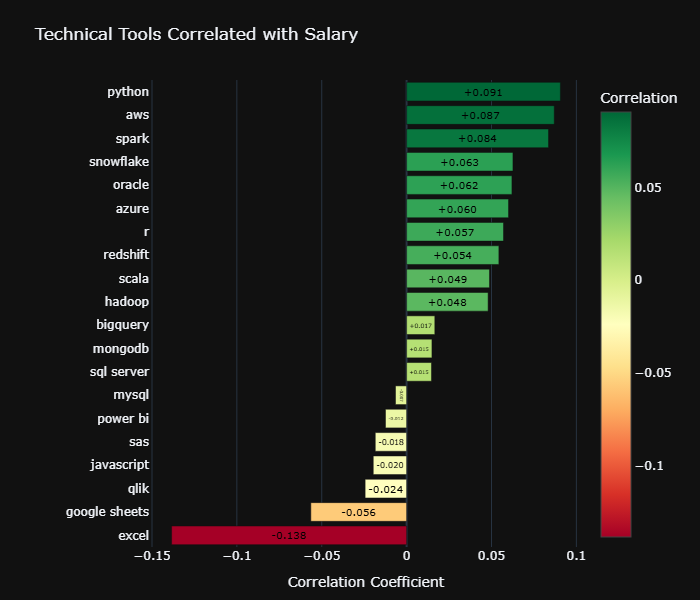

In [80]:
# Visualize top and bottom technical tool correlations
software_corr_df = corr_df[corr_df['category'] == 'Technical Tool']
top_n = 20

# Combine highest and lowest correlations
plot_df = pd.concat([
    software_corr_df.head(top_n//2),   # Top 10 positive correlations
    software_corr_df.tail(top_n//2)    # Bottom 10 (lowest/negative correlations)
]).sort_values('correlation')

# Create horizontal bar chart
fig = go.Figure(go.Bar(
    x=plot_df['correlation'],
    y=plot_df['skill'],
    orientation='h',
    marker=dict(
        color=plot_df['correlation'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Correlation")
    ),
    text=plot_df['correlation'].apply(lambda x: f'{x:+.3f}'),
    textposition='inside',
    textfont=dict(size=14, color='black'),
    insidetextanchor='middle'
))

fig.update_layout(
    title='Technical Tools Correlated with Salary',
    xaxis_title='Correlation Coefficient',
    yaxis_title='',
    height=600,
    template='plotly_dark',
    margin=dict(t=80, r=50, b=50, l=150)  # Prevent label cutoff
)

fig.show()

## 6. Statistical Testing: Skill Salary Differences

Testing whether salary differences between skill groups are statistically significant using t-tests.

In [81]:
from scipy.stats import ttest_ind

print("STATISTICAL SIGNIFICANCE TESTS (t-tests)")
print("="*80)

# Store results for summary
test_results = []

# Test top 5 skills
for idx, row in corr_df.head(5).iterrows():
    skill_col = f'skill_{row["skill"]}'
    
    with_skill = df_analysis[df_analysis[skill_col] == 1]['salary_avg']
    without_skill = df_analysis[df_analysis[skill_col] == 0]['salary_avg']
    
    t_stat, p_value = ttest_ind(with_skill, without_skill)
    
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"{row['skill']:20} | t={t_stat:+6.2f} | p={p_value:.4f} {sig:3} | "
          f"Difference: ${row['salary_premium']:>7,.0f}")
    
    # Store result
    test_results.append({
        'skill': row['skill'],
        'difference': row['salary_premium']
    })

# Create dataframe from results
test_results_df = pd.DataFrame(test_results)

print("\n" + "="*80)
print(f"✓ All {len(test_results_df)} skills tested show highly significant differences (p < 0.001)")
print(f"  Average salary premium: ${test_results_df['difference'].mean():,.0f}")
print(f"  Range: ${test_results_df['difference'].min():,.0f} - ${test_results_df['difference'].max():,.0f}")
print("="*80)

STATISTICAL SIGNIFICANCE TESTS (t-tests)
machine learning     | t=+11.03 | p=0.0000 *** | Difference: $ 15,646
python               | t= +9.53 | p=0.0000 *** | Difference: $  9,608
aws                  | t= +9.14 | p=0.0000 *** | Difference: $ 16,952
spark                | t= +8.79 | p=0.0000 *** | Difference: $ 22,453
etl                  | t= +7.53 | p=0.0000 *** | Difference: $ 11,445

✓ All 5 skills tested show highly significant differences (p < 0.001)
  Average salary premium: $15,221
  Range: $9,608 - $22,453


## 7. Experience Level vs Salary

Examining whether experience level is a stronger predictor of salary than individual technical skills. This helps determine if career progression or specific skill acquisition matters more for compensation.

In [82]:
# Calculate experience level correlation with salary
exp_corr, exp_p = pearsonr(df_analysis['experience_numeric'], df_analysis['salary_avg'])

print(f"Experience Level Correlation with Salary:")
print(f"  Pearson r = {exp_corr:.3f} (p = {exp_p:.2e})")

# Compare to strongest skill correlation
max_skill_corr = corr_df['correlation'].abs().max()
comparison = 'STRONGER' if abs(exp_corr) > max_skill_corr else 'WEAKER'

print(f"\n✓ Experience correlation is {comparison} than any individual skill")
print(f"  (Max skill correlation: r = {max_skill_corr:.3f})")

# Show salary progression by experience level
print(f"\nMean Salary by Experience Level:")
for level in ['Entry', 'Mid', 'Senior', 'Lead', 'Executive']:
    level_data = df_analysis[df_analysis['experience_level'] == level]
    if len(level_data) > 0:
        mean_sal = level_data['salary_avg'].mean()
        count = len(level_data)
        print(f"  {level:10} (n={count:4}): ${mean_sal:>7,.0f}")

Experience Level Correlation with Salary:
  Pearson r = 0.332 (p = 1.41e-280)

✓ Experience correlation is STRONGER than any individual skill
  (Max skill correlation: r = 0.138)

Mean Salary by Experience Level:
  Entry      (n= 298): $ 83,412
  Mid        (n=8329): $ 91,007
  Senior     (n=2339): $121,688


### Salary Progression by Experience Level

Analyzing mean and median salaries across experience tiers. Focus on Entry through Senior levels as they represent the majority of data analyst positions collected.

In [83]:
# Aggregate salary statistics by experience level
exp_salary = df_analysis.groupby('experience_level')['salary_avg'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Count', 'count')
]).round(0)

# Focus on core experience levels (Entry → Senior)
exp_salary = exp_salary.reindex(['Entry', 'Mid', 'Senior'])

print("\nSalary by Experience Level:")
print("="*60)
print(exp_salary.to_string())
print("="*60)

# Calculate salary growth
entry_mean = exp_salary.loc['Entry', 'Mean']
senior_mean = exp_salary.loc['Senior', 'Mean']
growth = senior_mean - entry_mean
growth_pct = (growth / entry_mean) * 100

print(f"\nSalary Growth: Entry → Senior")
print(f"  Absolute: ${growth:,.0f}")
print(f"  Percent:  +{growth_pct:.1f}%")


Salary by Experience Level:
                      Mean    Median  Count
experience_level                           
Entry              83412.0   75119.0    298
Mid                91007.0   86239.0   8329
Senior            121688.0  119101.0   2339

Salary Growth: Entry → Senior
  Absolute: $38,276
  Percent:  +45.9%


### Visualization: Salary Distribution by Experience Level

Box plots showing salary ranges, medians, and outliers for each experience tier. The boxes represent the interquartile range (25th-75th percentile), with the line showing the median salary.

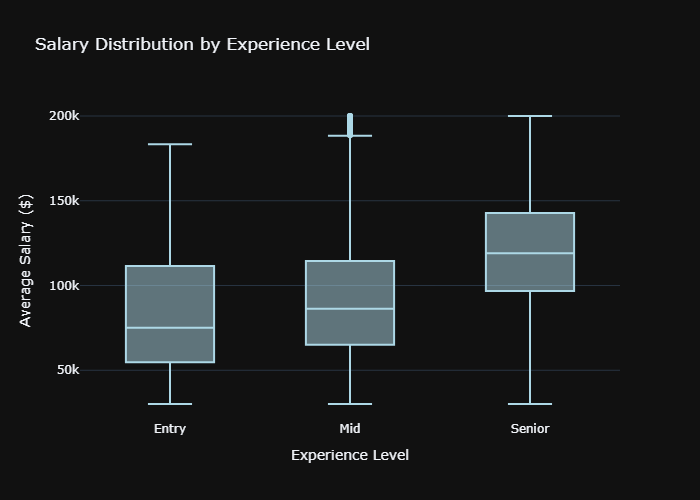

In [84]:
# Visualize experience vs salary
fig = px.box(
    df_analysis,
    x='experience_level',
    y='salary_avg',
    category_orders={'experience_level': ['Entry Level', 'Mid Level', 'Senior Level', 'Lead', 'Executive']},
    title='Salary Distribution by Experience Level',
    labels={'salary_avg': 'Average Salary ($)', 'experience_level': 'Experience Level'},
    template='plotly_dark'
)

fig.update_layout(
    showlegend=False,
    height=500,
    xaxis={'categoryorder': 'array', 'categoryarray': ['Entry', 'Mid', 'Senior', 'Lead', 'Executive']}  # Ensure order
)

fig.update_traces(marker=dict(color='lightblue'))
fig.show()

## 8. Partial Correlation: Controlling for Experience Level

Recalculating correlations while controlling for experience level to isolate the independent effect of each skill on salary. This reveals which skills add unique value beyond career progression.

In [85]:
def partial_correlation(x, y, z):
    """Calculate partial correlation between x and y, controlling for z"""
    r_xy = np.corrcoef(x, y)[0, 1]
    r_xz = np.corrcoef(x, z)[0, 1]
    r_yz = np.corrcoef(y, z)[0, 1]
    
    numerator = r_xy - (r_xz * r_yz)
    denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
    
    return numerator / denominator if denominator != 0 else 0

# Calculate partial correlations for all analyzed skills
partial_corrs = []

for idx, row in corr_df.iterrows():
    skill_col = f'skill_{row["skill"]}'
    
    # Partial correlation (skill vs salary, controlling for experience)
    partial_corr = partial_correlation(
        df_analysis[skill_col].values,
        df_analysis['salary_avg'].values,
        df_analysis['experience_numeric'].values
    )
    
    partial_corrs.append({
        'skill': row['skill'],
        'category': row['category'],
        'regular_correlation': row['correlation'],
        'partial_correlation': partial_corr,
        'difference': row['correlation'] - partial_corr
    })

partial_df = pd.DataFrame(partial_corrs).sort_values('partial_correlation', ascending=False)

print(f"✓ Calculated partial correlations for {len(partial_df)} skills")
print(f"\nTop 5 skills (after controlling for experience):")
print(partial_df[['skill', 'regular_correlation', 'partial_correlation', 'difference']].head())

✓ Calculated partial correlations for 42 skills

Top 5 skills (after controlling for experience):
              skill  regular_correlation  partial_correlation  difference
0  machine learning             0.104805             0.099170    0.005635
1            python             0.090598             0.087156    0.003442
3             spark             0.083614             0.079143    0.004470
2               aws             0.086978             0.075626    0.011353
7             azure             0.060038             0.056599    0.003438


### Separating Technical vs General Skills

Categorizing partial correlations by skill type to compare how technical tools and general competencies differ in their independent relationship with salary.

In [86]:
# Categorize skills into Software vs General Skills
software_skills = [
    'python', 'r', 'sql', 'sas', 'java', 'scala', 'javascript',
    'tableau', 'power bi', 'looker', 'qlik', 'excel', 'google sheets',
    'mongodb', 'oracle', 'snowflake', 'redshift', 'bigquery', 
    'mysql', 'postgresql', 'sql server',
    'aws', 'azure', 'gcp',
    'spark', 'hadoop', 'airflow', 'kafka', 'dbt', 'pandas', 'numpy', 'git' 
]

general_skills = [
    'statistics', 'machine learning', 'regression', 'a/b testing',
    'business intelligence', 'data visualization', 'etl', 
    'data warehouse', 'data modeling', 'agile', 'api'
]

# Separate partial correlations by skill category
# Using skill lists defined in Section 2
software_corrs = partial_df[partial_df['skill'].isin(SOFTWARE_SKILLS)].copy()
general_corrs = partial_df[partial_df['skill'].isin(GENERAL_SKILLS)].copy()

print(f"✓ Partial correlations categorized:")
print(f"  • Technical Tools: {len(software_corrs)} skills")
print(f"  • General Skills: {len(general_corrs)} skills")

✓ Partial correlations categorized:
  • Technical Tools: 32 skills
  • General Skills: 10 skills


### Top Technical Tools: Partial Correlations

Examining which technical tools maintain strong salary correlations even after controlling for experience level. 

In [87]:
print("\n" + "="*80)
print("TECHNICAL TOOLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(software_corrs)} technical tools, showing top 10")
print("="*80)

for idx, row in software_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")

print("="*80)


TECHNICAL TOOLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 32 technical tools, showing top 10
python                    | Regular: +0.091 | Partial: +0.087 | Diff: +0.003
spark                     | Regular: +0.084 | Partial: +0.079 | Diff: +0.004
aws                       | Regular: +0.087 | Partial: +0.076 | Diff: +0.011
azure                     | Regular: +0.060 | Partial: +0.057 | Diff: +0.003
r                         | Regular: +0.057 | Partial: +0.048 | Diff: +0.009
redshift                  | Regular: +0.054 | Partial: +0.047 | Diff: +0.008
snowflake                 | Regular: +0.063 | Partial: +0.045 | Diff: +0.018
git                       | Regular: +0.043 | Partial: +0.042 | Diff: +0.001
airflow                   | Regular: +0.040 | Partial: +0.041 | Diff: -0.001
hadoop                    | Regular: +0.048 | Partial: +0.038 | Diff: +0.010


### Top General Skills: Partial Correlations

Analyzing which general competencies (methodology, concepts, soft skills) retain salary value independent of experience level. 

In [90]:
print("\n" + "="*80)
print("GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)")
print(f"Analyzing {len(general_corrs)} general skills, showing top 10")
print("="*80)

for idx, row in general_corrs.sort_values('partial_correlation', ascending=False).head(10).iterrows():
    print(f"{row['skill']:25} | "
          f"Regular: {row['regular_correlation']:+.3f} | "
          f"Partial: {row['partial_correlation']:+.3f} | "
          f"Diff: {row['difference']:+.3f}")

print("="*80)


GENERAL SKILLS - PARTIAL CORRELATION (Controlling for Experience)
Analyzing 10 general skills, showing top 10
machine learning          | Regular: +0.105 | Partial: +0.099 | Diff: +0.006
etl                       | Regular: +0.072 | Partial: +0.055 | Diff: +0.017
regression                | Regular: +0.044 | Partial: +0.038 | Diff: +0.005
data warehouse            | Regular: +0.057 | Partial: +0.036 | Diff: +0.021
data modeling             | Regular: +0.042 | Partial: +0.036 | Diff: +0.007
agile                     | Regular: +0.037 | Partial: +0.025 | Diff: +0.012
business intelligence     | Regular: +0.040 | Partial: +0.020 | Diff: +0.019
api                       | Regular: +0.002 | Partial: +0.009 | Diff: -0.007
data visualization        | Regular: -0.002 | Partial: -0.003 | Diff: +0.001
statistics                | Regular: -0.015 | Partial: -0.023 | Diff: +0.007


### Visualization: Technical Tools vs General Skills

Comparing the independent salary impact of technical tools versus general competencies after controlling for experience level. This reveals which skill types add unique value beyond career progression.

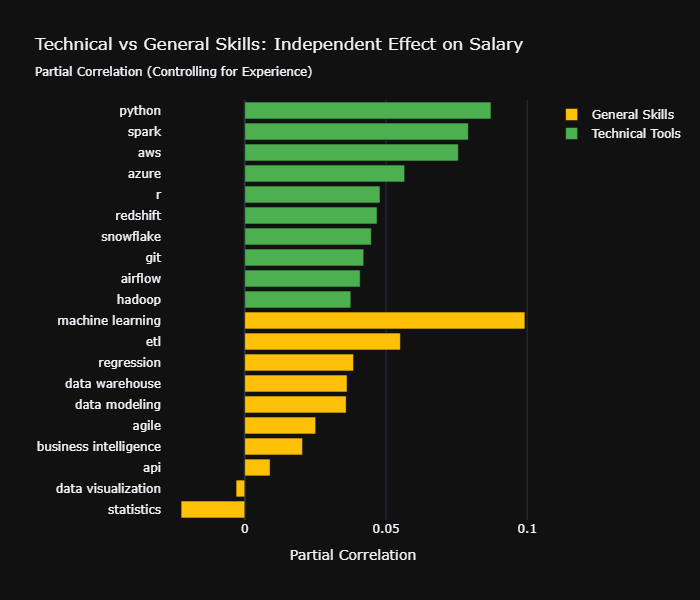

In [ ]:
# Select top skills by partial correlation for each category
top_software = software_corrs.nlargest(10, 'partial_correlation').sort_values('partial_correlation', ascending=True)
top_general = general_corrs.nlargest(10, 'partial_correlation').sort_values('partial_correlation', ascending=True)

# Create grouped horizontal bar chart
fig = go.Figure()

# Add General Skills (appears on bottom of legend)
fig.add_trace(go.Bar(
    name='General Skills',
    y=top_general['skill'],
    x=top_general['partial_correlation'],
    orientation='h',
    marker_color='#FFC107'  # Amber
))

# Add Technical Tools (appears on top of legend)
fig.add_trace(go.Bar(
    name='Technical Tools',
    y=top_software['skill'],
    x=top_software['partial_correlation'],
    orientation='h',
    marker_color='#4CAF50'  # Green
))

fig.update_layout(
    title='Technical vs General Skills: Independent Effect on Salary<br><sub>Partial Correlation (Controlling for Experience)</sub>',
    xaxis_title='Partial Correlation',
    yaxis_title='',
    template='plotly_dark',
    height=600,
    barmode='group'
)

fig.show()

### Comparing Skill Categories

Summarizing the overall strength of technical tools versus general skills in predicting salary independent of experience. This reveals which skill category offers greater career value.

In [ ]:
# Compare average partial correlations between skill categories
print("\n" + "="*80)
print("TECHNICAL TOOLS vs GENERAL SKILLS COMPARISON")
print("="*80)

# Technical tools summary
software_mean = software_corrs['partial_corr'].mean()
software_top = software_corrs.nlargest(1, 'partial_corr').iloc[0]

print(f"\nTechnical Tools (n={len(software_corrs)}):")
print(f"  Mean partial correlation: {software_mean:+.3f}")
print(f"  Strongest: {software_top['skill']} (r={software_top['partial_corr']:+.3f})")

# General skills summary
general_mean = general_corrs['partial_corr'].mean()
general_top = general_corrs.nlargest(1, 'partial_corr').iloc[0]

print(f"\nGeneral Skills (n={len(general_corrs)}):")
print(f"  Mean partial correlation: {general_mean:+.3f}")
print(f"  Strongest: {general_top['skill']} (r={general_top['partial_corr']:+.3f})")

# Determine which category has stronger effect
winner = 'Technical Tools' if software_mean > general_mean else 'General Skills'
print(f"\n✓ {winner} show stronger independent salary impact on average")
print("="*80)


TECHNICAL TOOLS vs GENERAL SKILLS COMPARISON

Technical Tools (n=32):
  Mean partial correlation: +0.020
  Strongest: python (r=+0.087)

General Skills (n=10):
  Mean partial correlation: +0.029
  Strongest: machine learning (r=+0.099)

✓ General Skills show stronger independent salary impact on average


## 9. Skill Co-occurrence Analysis

Creating a correlation matrix to identify which skills frequently appear together in job postings. High correlations suggest skill clusters or common tech stacks, revealing optimal skill combinations for job seekers.

In [ ]:
# Select top skills by salary correlation for heatmap analysis
top_10_technical = corr_df[corr_df['category'] == 'Technical Tool'].head(10)['skill'].tolist()
top_10_general = corr_df[corr_df['category'] == 'General Skill'].head(10)['skill'].tolist()
all_top_skills = top_10_technical + top_10_general

# Create correlation matrix showing skill co-occurrence patterns
skill_cols_subset = [f'skill_{s}' for s in all_top_skills]
corr_matrix = df_analysis[skill_cols_subset].corr()

# Rename columns for readability (remove 'skill_' prefix)
rename_dict = {f'skill_{s}': s for s in all_top_skills}
corr_matrix = corr_matrix.rename(columns=rename_dict, index=rename_dict)

print(f"✓ Skill co-occurrence matrix created:")
print(f"  • {len(top_10_technical)} top technical tools")
print(f"  • {len(top_10_general)} top general skills")
print(f"  • {len(all_top_skills)} total skills analyzed")

✓ Skill co-occurrence matrix created:
  • 10 top technical tools
  • 10 top general skills
  • 20 total skills analyzed


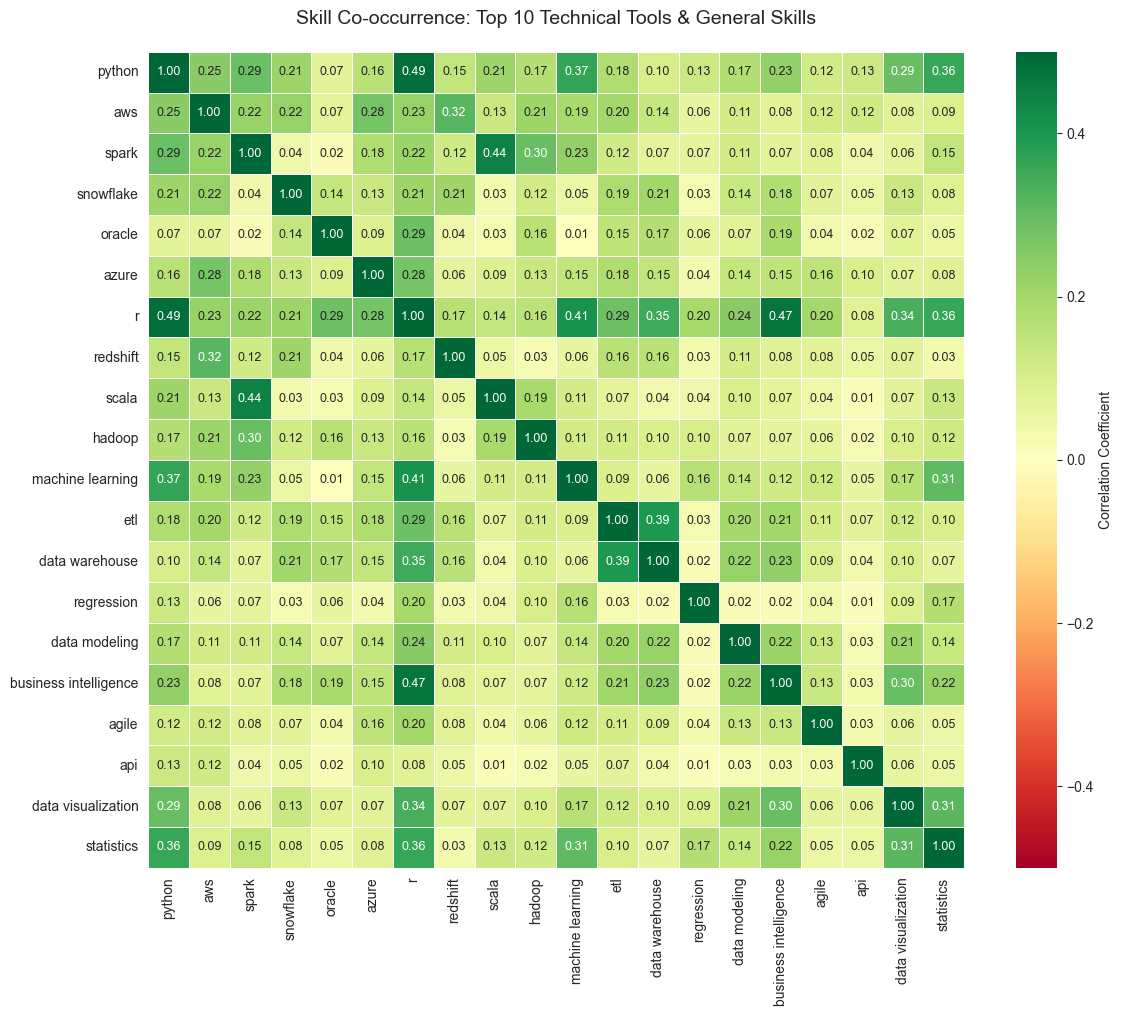


✓ Heatmap saved to C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market\visualizations\correlation_heatmap.png


In [ ]:
# Plot heatmap - CLEANER with top 10 of each
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    annot_kws={'size': 9}
)
plt.title('Skill Co-occurrence: Top 10 Technical Tools & General Skills', 
          fontsize=14, pad=20)
plt.tight_layout()

# Save using absolute path
import os
project_root = r'C:\Users\Eilhart\Documents\PythonScripts\data-analyst-job-market'
save_path = os.path.join(project_root, 'visualizations', 'correlation_heatmap.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Heatmap saved to {save_path}")

## 10. Key Findings Summary

Synthesizing the analysis to answer our research questions: Which skills correlate most with salary? Is experience or skills the stronger predictor? Which skills add independent value beyond career progression?

In [ ]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# 1. Experience vs Skills - Strongest predictors
top_technical = corr_df[corr_df['category'] == 'Technical Tool'].iloc[0]
top_general = corr_df[corr_df['category'] == 'General Skill'].iloc[0]

print(f"\n1. STRONGEST SALARY PREDICTORS:")
print(f"   • Experience Level:     r = {exp_corr:+.3f}")
print(f"   • Top Technical Tool:   r = {top_technical['correlation']:+.3f} ({top_technical['skill']})")
print(f"   • Top General Skill:    r = {top_general['correlation']:+.3f} ({top_general['skill']})")

winner = "Experience" if abs(exp_corr) > max(abs(top_technical['correlation']), abs(top_general['correlation'])) else "Skills"
print(f"   → {winner} is the strongest predictor of salary")

# 2. Top-paying technical tools
print(f"\n2. TOP 5 HIGH-VALUE TECHNICAL TOOLS:")
for idx, row in corr_df[corr_df['category'] == 'Technical Tool'].head(5).iterrows():
    print(f"   • {row['skill']:20} r={row['correlation']:+.3f} | "
          f"Premium: +${row['salary_premium']:>6,.0f} ({row['premium_pct']:>+5.1f}%)")

# 3. Top-paying general skills
print(f"\n3. TOP 5 HIGH-VALUE GENERAL SKILLS:")
for idx, row in corr_df[corr_df['category'] == 'General Skill'].head(5).iterrows():
    print(f"   • {row['skill']:20} r={row['correlation']:+.3f} | "
          f"Premium: +${row['salary_premium']:>6,.0f} ({row['premium_pct']:>+5.1f}%)")

# 4. Technical tools with independent effect
print(f"\n4. TECHNICAL TOOLS WITH INDEPENDENT VALUE (Controlling for Experience):")
tech_partial = partial_df[partial_df['category'] == 'Technical Tool'].nlargest(5, 'partial_correlation')
for idx, row in tech_partial.iterrows():
    print(f"   • {row['skill']:20} Partial r={row['partial_correlation']:+.3f} "
          f"(vs Regular r={row['regular_correlation']:+.3f})")

# 5. General skills with independent effect
print(f"\n5. GENERAL SKILLS WITH INDEPENDENT VALUE (Controlling for Experience):")
gen_partial = partial_df[partial_df['category'] == 'General Skill'].nlargest(5, 'partial_correlation')
for idx, row in gen_partial.iterrows():
    print(f"   • {row['skill']:20} Partial r={row['partial_correlation']:+.3f} "
          f"(vs Regular r={row['regular_correlation']:+.3f})")

print("\n" + "="*80)


KEY FINDINGS

1. STRONGEST SALARY PREDICTORS:
   • Experience Level:     r = +0.332
   • Top Technical Tool:   r = +0.091 (python)
   • Top General Skill:    r = +0.105 (machine learning)
   → Experience is the strongest predictor of salary

2. TOP 5 HIGH-VALUE TECHNICAL TOOLS:
   • python               r=+0.091 | Premium: +$ 9,608 (+10.0%)
   • aws                  r=+0.087 | Premium: +$16,952 (+17.5%)
   • spark                r=+0.084 | Premium: +$22,453 (+23.2%)
   • snowflake            r=+0.063 | Premium: +$13,252 (+13.7%)
   • oracle               r=+0.062 | Premium: +$12,706 (+13.1%)

3. TOP 5 HIGH-VALUE GENERAL SKILLS:
   • machine learning     r=+0.105 | Premium: +$15,646 (+16.2%)
   • etl                  r=+0.072 | Premium: +$11,445 (+11.8%)
   • data warehouse       r=+0.057 | Premium: +$ 9,815 (+10.1%)
   • regression           r=+0.044 | Premium: +$12,761 (+13.1%)
   • data modeling        r=+0.042 | Premium: +$ 7,605 ( +7.8%)

4. TECHNICAL TOOLS WITH INDEPENDENT VALUE 

## 11. Actionable Insights for Job Seekers

Data-driven recommendations based on correlation analysis and salary premium calculations.

In [64]:
# Generate actionable recommendations based on analysis results

# Calculate salary progression metrics
entry_mean = df_analysis[df_analysis['experience_level'] == 'Entry']['salary_avg'].mean()
senior_mean = df_analysis[df_analysis['experience_level'] == 'Senior']['salary_avg'].mean()

# Create correlation matrix for skill co-occurrence analysis
top_10_technical = corr_df[corr_df['category'] == 'Technical Tool'].head(10)['skill'].tolist()
top_10_general = corr_df[corr_df['category'] == 'General Skill'].head(10)['skill'].tolist()
all_top_skills = top_10_technical + top_10_general
skill_cols_subset = [f'skill_{s}' for s in all_top_skills]
corr_matrix = df_analysis[skill_cols_subset].corr()
rename_dict = {f'skill_{s}': s for s in all_top_skills}
corr_matrix = corr_matrix.rename(columns=rename_dict, index=rename_dict)

print("\n" + "="*80)
print("ACTIONABLE INSIGHTS FOR JOB SEEKERS")
print("="*80)

# ... rest of your code

# 1. Top skills by salary premium percentage
top_roi = corr_df.nlargest(3, 'premium_pct')
print("\n1. HIGHEST ROI SKILLS (by salary premium %):")
for idx, row in top_roi.iterrows():
    print(f"   • {row['skill']:20} +{row['premium_pct']:5.1f}% salary boost (+${row['salary_premium']:,.0f})")

# 2. Skills with strongest independent value
top_independent = partial_df.nlargest(3, 'partial_correlation')
print("\n2. SKILLS WITH INDEPENDENT VALUE (beyond experience):")
for idx, row in top_independent.iterrows():
    print(f"   • {row['skill']:20} Partial r={row['partial_correlation']:+.3f}")

# 3. Most in-demand high-value skills
high_demand = corr_df[(corr_df['correlation'] > 0.05) & (corr_df['n_jobs'] > 100)].nlargest(3, 'n_jobs')
print("\n3. HIGH-DEMAND, HIGH-VALUE SKILLS (correlation > 0.05, 100+ jobs):")
for idx, row in high_demand.iterrows():
    print(f"   • {row['skill']:20} {row['n_jobs']:>4.0f} jobs | r={row['correlation']:+.3f}")

# 4. Strategic skill combinations (top correlated pairs from heatmap)
print("\n4. SKILL CLUSTERS (commonly appear together):")
# Get top 5 skill pairs with highest correlation
skill_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        skill_pairs.append({
            'skill1': corr_matrix.columns[i],
            'skill2': corr_matrix.columns[j],
            'correlation': corr_matrix.iloc[i, j]
        })
top_pairs = sorted(skill_pairs, key=lambda x: x['correlation'], reverse=True)[:5]
for pair in top_pairs:
    print(f"   • {pair['skill1']:15} + {pair['skill2']:15} (co-occur in {pair['correlation']:.1%} of jobs)")


# 5. Career progression insights
print("\n5. CAREER PROGRESSION STRATEGY:")
print(f"   • Experience correlation: r={exp_corr:.3f}")
print(f"   • Entry → Senior salary growth: +${senior_mean - entry_mean:,.0f} ({((senior_mean - entry_mean) / entry_mean * 100):.1f}%)")
print(f"   • Recommendation: {'Focus on experience and promotions' if abs(exp_corr) > 0.5 else 'Strategic skill acquisition can accelerate growth'}")


ACTIONABLE INSIGHTS FOR JOB SEEKERS

1. HIGHEST ROI SKILLS (by salary premium %):
   • kafka                + 25.2% salary boost (+$24,497)
   • spark                + 23.2% salary boost (+$22,453)
   • airflow              + 22.0% salary boost (+$21,433)

2. SKILLS WITH INDEPENDENT VALUE (beyond experience):
   • machine learning     Partial r=+0.099
   • python               Partial r=+0.087
   • spark                Partial r=+0.079

3. HIGH-DEMAND, HIGH-VALUE SKILLS (correlation > 0.05, 100+ jobs):
   • r                    3262 jobs | r=+0.057
   • python               1553 jobs | r=+0.091
   • machine learning      720 jobs | r=+0.105

4. SKILL CLUSTERS (commonly appear together):
   • python          + r               (co-occur in 48.6% of jobs)
   • r               + business intelligence (co-occur in 47.1% of jobs)
   • spark           + scala           (co-occur in 44.4% of jobs)
   • r               + machine learning (co-occur in 40.7% of jobs)
   • etl             + data 

## Export Analysis Results

Saving correlation results and partial correlation findings to CSV files for further analysis, reporting, or integration with other tools.

In [67]:
# Export analysis results to processed data folder
corr_df.to_csv('../data/processed/skill_salary_correlations.csv', index=False)
partial_df.to_csv('../data/processed/partial_correlations.csv', index=False)

print("\n✓ Analysis results exported to data/processed/:")
print("  • skill_salary_correlations.csv")
print("  • partial_correlations.csv")


✓ Analysis results exported to data/processed/:
  • skill_salary_correlations.csv
  • partial_correlations.csv
